In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib.colors import ListedColormap
import rasterio
from rasterio.mask import mask

In [2]:
counties = gpd.read_file("counties.geojson")
# counties

In [3]:
#Q1
len(counties)

72

<Axes: >

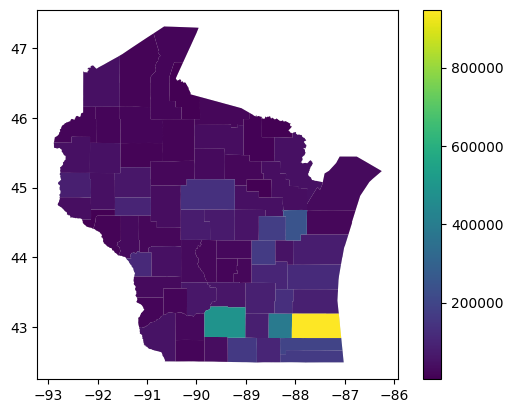

In [4]:
#Q2
gdf = gpd.read_file("tracts.shp")
ax = gdf.plot(facecolor="lightgray")
counties.plot(column = "POP100",cmap="viridis",ax=ax, legend=True)

In [5]:
conn = sqlite3.connect("counties_tracts.db")
tables = pd.read_sql("""SELECT * FROM sqlite_master""", conn)
# counties, tracts
arealand = pd.read_sql("""SELECT AREALAND FROM counties""", conn)
# tables
counties["AREALAND"] = arealand
# counties
train, test = train_test_split(counties, random_state=320, test_size=0.25)

In [6]:
#Q3
test["NAME"].tolist()

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [7]:
#Q4
model = LinearRegression()
xcols = ["AREALAND"]
ycol = "POP100"
model.fit(train[xcols], train[ycol])
y = model.predict(test[xcols])
model.score(test[xcols], test[ycol])

0.022002661530554857

In [8]:
#predicted population of a county with 300 square miles of area, according to the model
#arealand = sq meters
counties2 = counties
counties2["AREALAND"] = (counties["AREALAND"]/1000000)/2.59

In [9]:
#Q5
train2, test2 = train_test_split(counties2, random_state=320, test_size=0.25)
model2 = LinearRegression()
x2col = ["AREALAND"]
y2col = "POP100"
model2.fit(train2[x2col], train2[y2col])
predict_df = pd.DataFrame({"AREALAND": [300]})
predict_df["PredictedPop"] = model2.predict(predict_df)
predict_df["PredictedPop"][0]

89016.40396725973

In [10]:
connection = sqlite3.connect("counties_tracts.db")
#got help from TA during lab
hu100 = pd.read_sql("""
SELECT counties.NAME, SUM(tracts.HU100)
FROM counties
INNER JOIN tracts
ON counties.COUNTY == tracts.COUNTY 
GROUP BY counties.NAME""", connection)

# hu100

In [11]:
# counties["HU100"] = HU100
counties = pd.merge(counties, hu100, on = "NAME")
counties = counties.rename(columns={'SUM(tracts.HU100)': 'HU100'})
# counties

In [12]:
train2, test2 = train_test_split(counties, random_state=320, test_size=0.25)

In [13]:
#Q6
test2["NAME"].to_list()

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [14]:
#Q7
names = test2["NAME"].to_list()
numUnits = test2["HU100"].to_list()
#copied from https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/
ans7 = dict(zip(names, numUnits))
ans7

{'Kewaunee County': 9304,
 'Calumet County': 19695,
 'Adams County': 17436,
 'Eau Claire County': 42151,
 'Milwaukee County': 418053,
 'Ashland County': 9656,
 'Wood County': 34088,
 'Dodge County': 37005,
 'Sauk County': 29708,
 'Clark County': 15076,
 'Pepin County': 3579,
 'Taylor County': 10582,
 'Iron County': 5999,
 'Outagamie County': 73149,
 'Florence County': 4780,
 'Oneida County': 30125,
 'Pierce County': 16132,
 'Grant County': 21581}

In [15]:
#Q8
model = LinearRegression()
xcols = ["HU100"]
ycol = "POP100"
scores = cross_val_score(model, train2[xcols], train2[ycol], cv = 5)
scores.mean()

0.9652534544116037

In [16]:
#Q9
sd = scores.std()
sd

0.03704265206670459

In [17]:
#Q10
model.fit(train2[xcols], train2[ycol])
slope = str(round(model.coef_[0],2))
intercept = str(round(model.intercept_,2))
ans = "POP100 = " + slope + "*HU100 + " + intercept
ans

'POP100 = 2.39*HU100 + -7910.46'

In [18]:
#Q11
predictions = model.predict(test2[xcols])
sklearn.metrics.r2_score(test2[ycol], predictions)

0.9958323488562859

Text(0.5, 1.0, 'POP100 vs. HU100')

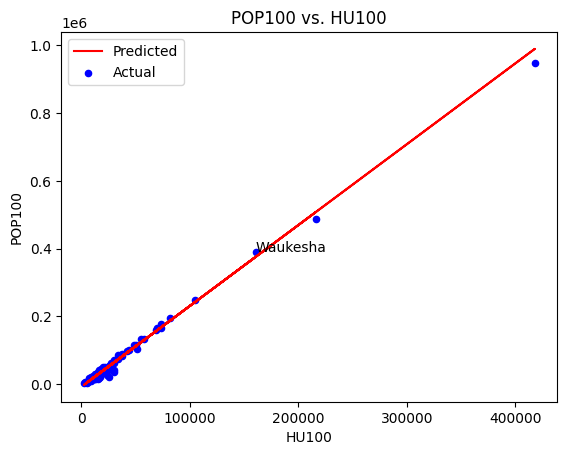

In [19]:
#Q12
predict_df = pd.DataFrame({'HU100': counties["HU100"]})
predict_df["predictedPOP100"] = model.predict(counties[xcols])
# predict_df
label = 0
for i in range(len(counties)):
    if counties.loc[i].NAME == "Waukesha County":
        label = i
# label
ax = predict_df.plot.line(x="HU100", y="predictedPOP100", color="r")
plt = counties.plot.scatter(x="HU100", y="POP100", ax=ax, color="blue")

#copied from https://www.geeksforgeeks.org/matplotlib-pyplot-legend-in-python/
plt.legend(["Predicted", "Actual"])
plt.text(counties.loc[label].HU100, counties.loc[label].POP100, 'Waukesha')
plt.set_title("POP100 vs. HU100")


In [20]:
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

In [21]:
#Q13
count = 0
# len(A)
for a in A:
    for b in a:
        if b >= 1 and b <= 4:
            count += 1
count

13

In [22]:
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

In [23]:
land = rasterio.open("zip://./land.zip!/wi.tif")
label = 0
for i in range(len(counties)):
    if counties.loc[i].NAME == "Dane County":
        label = i
newCounties = gpd.read_file("counties.geojson")
# dane.crs
dane = newCounties.loc[[label]]
# dane.plot()
# type(dane)

In [24]:
# from rasterio.mask import mask
matrix, _ = mask(land, dane.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]
# matrix

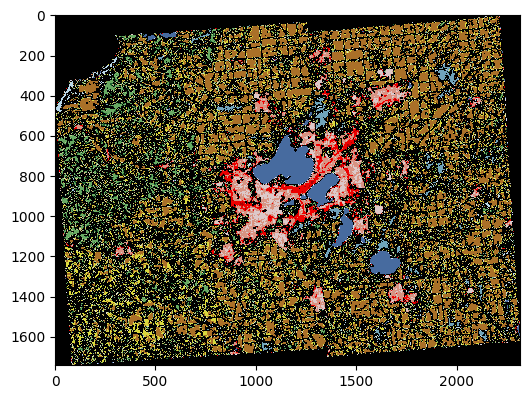

In [25]:
#Q14
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(matrix, cmap=custom_cmap, vmin=0, vmax=255)


In [26]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

In [27]:
#Q15
matrix2 = matrix.copy()
# matrix2
matrix2[matrix2 == 0] = 1
count2 = 0
for i in matrix2:
    for j in i:
        if j != 1:
            count2 += 1
count2
# matrix2
((matrix2 % land_use.get("crops") == 0).astype(int).sum())/count2

0.46705544316564085

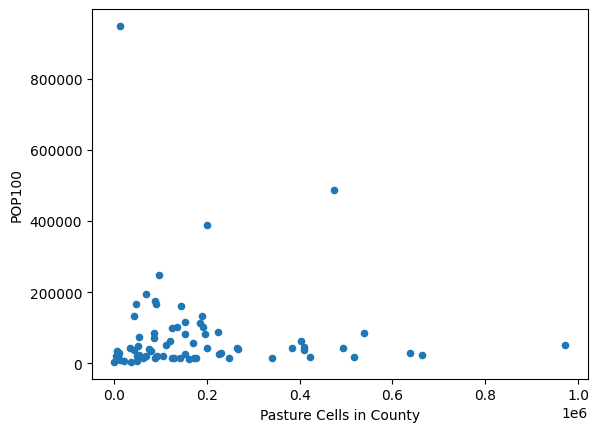

In [28]:
#Q16
#got help from TA/PM office hours(Mark)
from rasterio.mask import mask
land = rasterio.open("zip://./land.zip!/wi.tif")
df2 = pd.DataFrame({'POP100': counties["POP100"]})
df2
masks = []
for name in counties["NAME"]:
# for geom in counties.to_crs(land.crs)["geometry"]:
    df = counties[counties["NAME"] == name]
    m, _ = mask(land, df.to_crs(land.crs)['geometry'], crop=True)
    m = m[0]
    # print(df['POP100'].astype(int), np.sum(m == land_use.get("open_water")))
    masks.append(np.sum(m == land_use.get("pasture")))

df2["Pasture"] = masks
# plt2 = df2.scatter(x="POP100", y="water")
plt2 = df2.plot.scatter(x="Pasture", y="POP100", xlabel='Pasture Cells in County')
# plt2

In [29]:
tracts = gpd.read_file("tracts.shp")
masks
for key in land_use:
    masks = []
    for geom in tracts.to_crs(land.crs)["geometry"]:
        # df = counties[counties["NAME"] == name]
        m, _ = mask(land, [geom], crop=True)
        m = m[0]
        masks.append(np.sum(m == land_use.get(key)))
    tracts[key] = masks
# tracts

In [30]:
geotrain, geotest = train_test_split(tracts, random_state=320, test_size=0.20)
xcols = ['open_water', 'ice_snow', 'developed_open', 'developed_low',
        'developed_med', 'developed_high', 'barren', 'deciduous',
        'evergreen', 'mixed_forest', 'dwarf_scrub', 'shrub_scrub', 'grassland', 'sedge',
        'lichens', 'moss', 'pasture', 'crops', 'woody_wetlands', 'herbacious_wetlands']
ycol = "POP100"

geoModel = LinearRegression()
geoModel.fit(geotrain[xcols], geotrain[ycol])
# geoModel.score(geotest[xcols], geotest[ycol]) 

LinearRegression()

<Axes: >

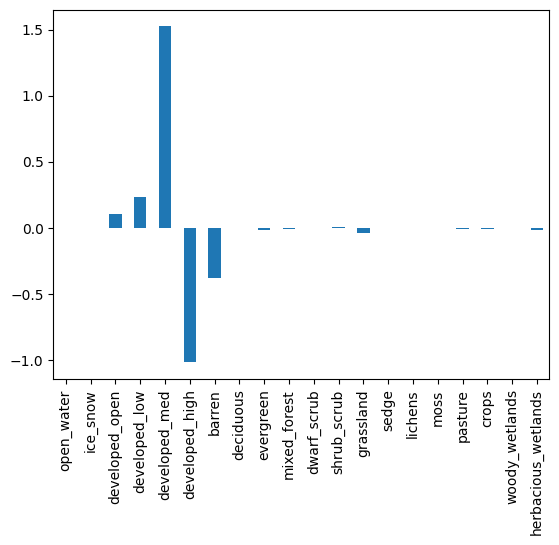

In [31]:
#Q17
geoModel.coef_
pd.Series(geoModel.coef_, index=xcols).plot.bar()
# The graph is showing the amount of weight that each feature in the land-use dictionary has on the regression model
# to predict the population of a certain area by either positively or negatively impacting the population prediction. 
# When building a model, I might use this information to pick features that contains significant, non-zero weights 
# on the prediction of the population of a certain area, since the non-zero weights would not benefit the prediction
# as much as the features with significant weights, regardless of if it is positive or negative. 


In [32]:
# Model1 features: developed_med, developed_high, barren, developed_low, developed_open, developed_med, 
# Model2 featurs: developed_low, developed_open, developed_med, shrub_scrub, grassland

In [33]:
#Q18
metrics = {}
#Model 1
x1cols = ['developed_open', 'developed_low', 'developed_med', 'developed_high', 'barren']
y1col = "POP100"
model1 = LinearRegression()
model1.fit(geotrain[x1cols], geotrain[y1col])
model1Scores = cross_val_score(model1, geotrain[x1cols], geotrain[y1col], cv=10)
metrics["model1-avg"] = model1Scores.mean()
metrics['model1-std'] = model1Scores.std()

#Model 2
x2cols = ['developed_open', 'developed_low', 'developed_med', 'shrub_scrub', 'grassland']
y2col = "POP100"
model2 = LinearRegression()
model2.fit(geotrain[x2cols], geotrain[y2col])
model2Scores = cross_val_score(model2, geotrain[x2cols], geotrain[y2col], cv=10)
metrics["model2-avg"] = model2Scores.mean()
metrics['model2-std'] = model2Scores.std()
metrics
# I recommend using the first model with training features: developed_open, developed_low, developed_med, 
# developed_high, and barren because the mean of the 10 fold cross validation score is higher for the first 
# model by 0.042, and it has a smaller standard deviation than the second model by 0.0031. This means that the
# first model should do better than the second model when testing. Both models have the same number of features and 
# incorporate three of the same features - developed_open, developed_low, and developed_med - so these models are 
# showing how the interactions of these three features and the other two different features change the predicted 
# population based on the interactions with each other and their individual weights. Since developed_high and barren 
# both have very negative weights on the population prediction, while both shrub_scrub and grassland have significantly
# less negative weights on the prediction in comparison.

{'model1-avg': 0.4524280436304921,
 'model1-std': 0.047516091188543705,
 'model2-avg': 0.41074230699179537,
 'model2-std': 0.05057283322697394}

In [34]:
#Q19
model1.fit(geotrain[x1cols], geotrain[y1col])
model1.score(geotest[x1cols], geotest[y1col]) 
model2.fit(geotrain[x2cols], geotrain[y2col])
model2.score(geotest[x2cols], geotest[y2col]) 

0.36365237930692473